In [1]:
import re
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_curve, auc
import skfuzzy as fuzz
import QFIE.FuzzyEngines as FE
from skfuzzy.defuzzify.exceptions import EmptyMembershipError
import membership
import rule_base
import mamdani
import wangmendel
import defuzz
from Examples.MackeyGlass import synthetic
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

In [2]:
df = pd.read_csv("./data_1/relevant_features_BATADAL.csv")
df["OUTCOME"] = df["OUTCOME"].map({-1: 1, 1: 0})
display(df)


,P_J307,P_J302,OUTCOME
0,0.138159,0.136014,1
1,0.281364,0.277972,1
2,0.282060,0.278671,1
3,0.310249,0.309266,1
4,0.322429,0.321503,1
...,...,...,...
4172,0.081782,0.079371,1
4173,0.202540,0.200874,1
4174,0.186184,0.184441,1
4175,0.191578,0.189860,1


In [3]:
X = df.drop(columns=['OUTCOME']).values
y = df['OUTCOME'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 🔹 Filtra solo dati normali nel training set
X_train = X_train[y_train == 0]
y_train = y_train[y_train == 0]  # Mantieni solo le etichette 0

# 🔹 Bilanciamento del test set: riduzione delle anomalie
normal_indices = np.where(y_test == 0)[0]
anomaly_indices = np.where(y_test == 1)[0]

# Imposta un rapporto equilibrato (ad esempio, 2:1 tra normali e anomalie)
n_normals = len(normal_indices)
n_anomalies = min(len(anomaly_indices), n_normals // 3)  # Mantieni meno anomalie rispetto ai normali

# Campionamento casuale delle anomalie
selected_anomaly_indices = np.random.choice(anomaly_indices, n_anomalies, replace=False)

# Creazione del nuovo test set bilanciato
selected_indices = np.concatenate([normal_indices, selected_anomaly_indices])
X_test, y_test = X_test[selected_indices], y_test[selected_indices]

# 🔹 Stampa le dimensioni dei dataset
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Numero di etichette 0 in y_test:", np.sum(y_test == 0))
print("Numero di etichette 1 in y_test:", np.sum(y_test == 1))

X_train shape: (175, 2)
y_train shape: (175,)
X_test shape: (58, 2)
y_test shape: (58,)
Numero di etichette 0 in y_test: 44
Numero di etichette 1 in y_test: 14


(175,)


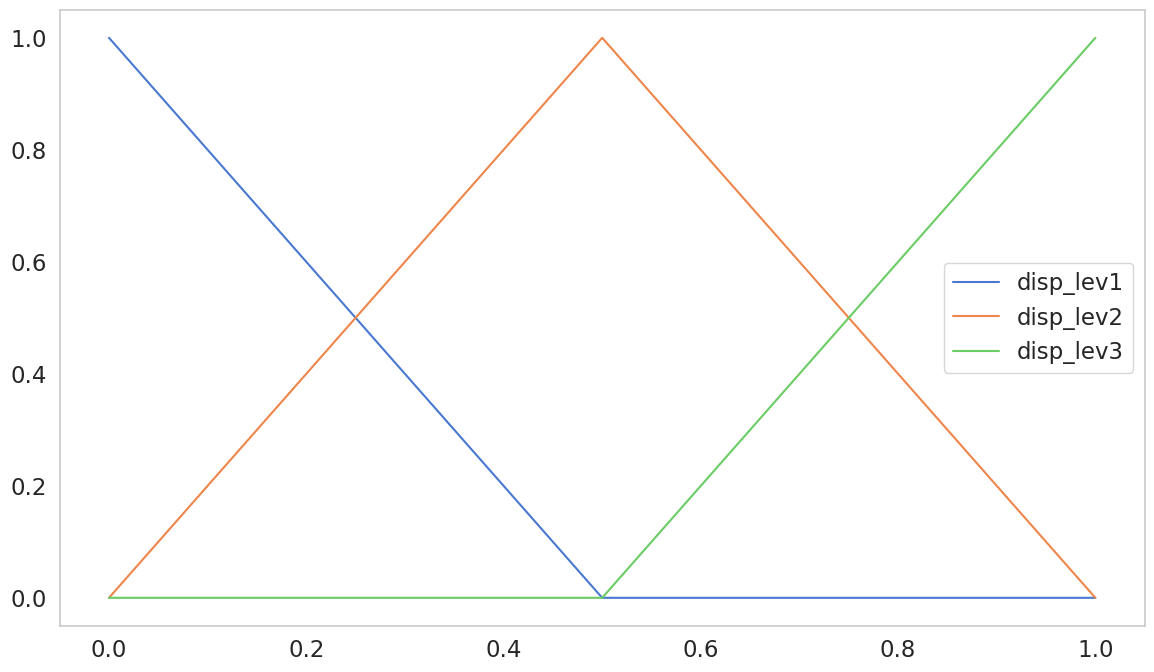

In [4]:
A = np.array(X_train)[:,0]
print(A.shape)

n_regions = 3
name_preffix = 'disp_lev'

fuzzy_regions = wangmendel.get_fuzzy_regions(A, n_regions, name_preffix)

# First we need to define the range of values on X-axis
ini = min(A)
end = max(A)

x = np.arange(ini, end, 0.001)

for region in fuzzy_regions:
    pertinence = np.vectorize(region.set.pertinence, otypes=[float])
    plt.plot(x, pertinence(x), label=region.name)
    
plt.legend()
plt.grid()

In [5]:
for region in fuzzy_regions:
    print(region)

disp_lev1 = inf_border(x, 0.0, 0.5000000000000001)
disp_lev2 = triang(x, 0.0, 0.5000000000000001, 1.0000000000000002)
disp_lev3 = sup_border(x, 0.5000000000000001, 1.0000000000000002)


In [6]:
rule_base = wangmendel.learn_fuzzy_rules(X_train, y_train,
                                        n_regions_inputs=[3,3],
                                        n_regions_output=2,
                                        name_preffix_inputs=['P_J307', 'P_J302'],
                                        name_preffix_output='Y')

In [7]:
print("The rule base has {} rules!".format(rule_base.size()))

The rule base has 175 rules!


In [8]:
rule_base = wangmendel.clean_rule_base(rule_base)
print("The cleaned rule base has {} rules!".format(rule_base.size()))

The cleaned rule base has 16 rules!


In [9]:
def calculate_reconstruction_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

errors = []
y_pred = []

for x in X_test:
    y, f_y = mamdani.predict_crisp(x, rule_base)
    predicted_value = defuzz.centroid(y, f_y)
    y_pred.append(predicted_value)
    error = calculate_reconstruction_error([y_test[len(y_pred) - 1]], [predicted_value])
    errors.append(error)

threshold = np.percentile(errors, 0)
print(f"Threshold for anomaly detection: {threshold}")

# Identificare le anomalie
anomalies = [error > threshold for error in errors]
print(f"Anomalies detected: {sum(anomalies)} out of {len(errors)}")

Threshold for anomaly detection: 0.0
Anomalies detected: 14 out of 58


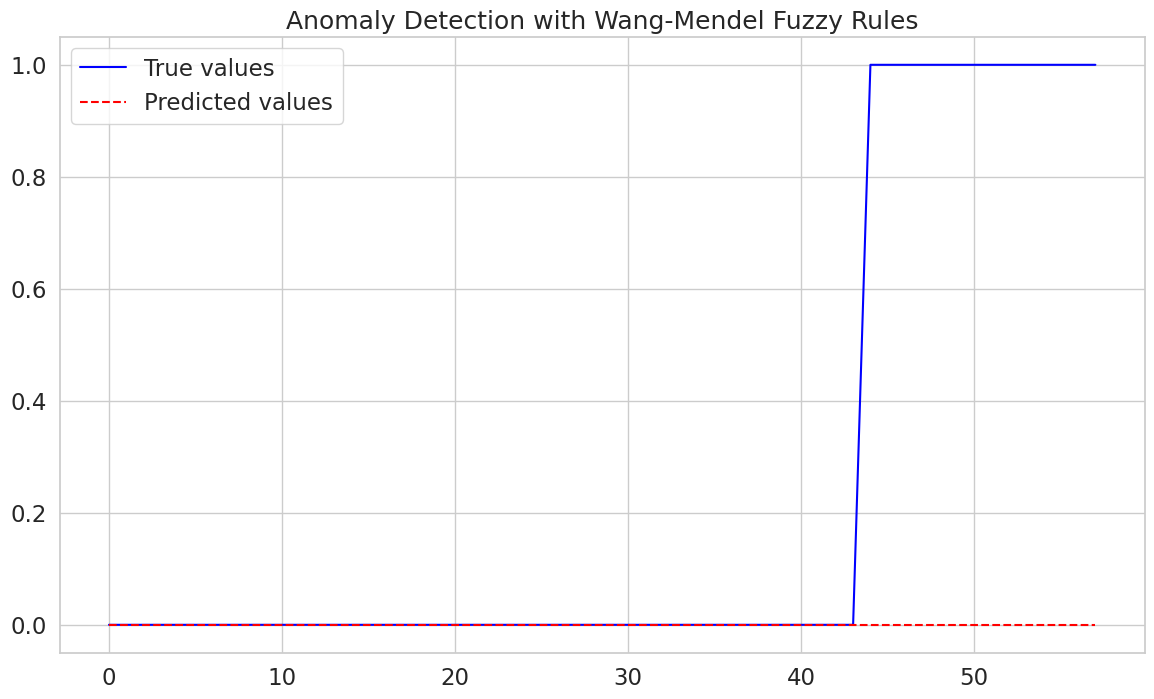

In [10]:
# Plot dei risultati
plt.plot(y_test, color='blue', label='True values')
plt.plot(y_pred, '--', color='red', label='Predicted values')
plt.legend()
plt.title("Anomaly Detection with Wang-Mendel Fuzzy Rules")
plt.show()

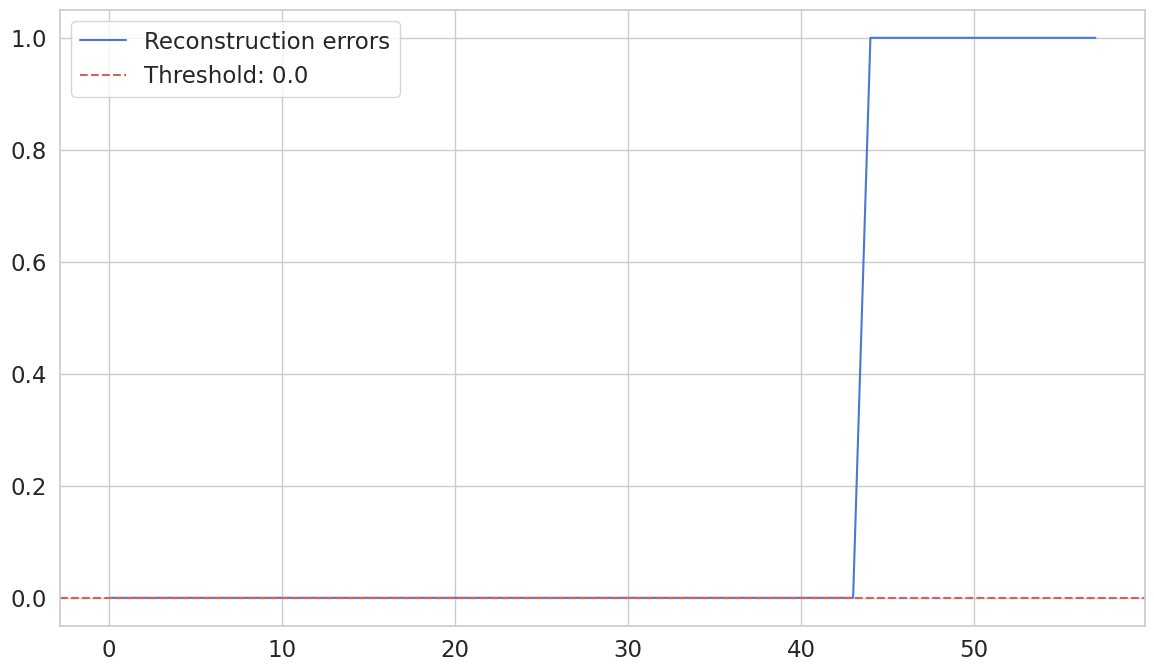

In [11]:
# Mostra le anomalie nel test set
threshold_str = str(threshold)  # Converti in stringa
threshold_str = threshold_str[:threshold_str.find('.') + 4]  # Prendi solo le prime 2 cifre dopo la virgola

plt.plot(errors, label='Reconstruction errors')
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold_str}")
plt.legend()
plt.show()

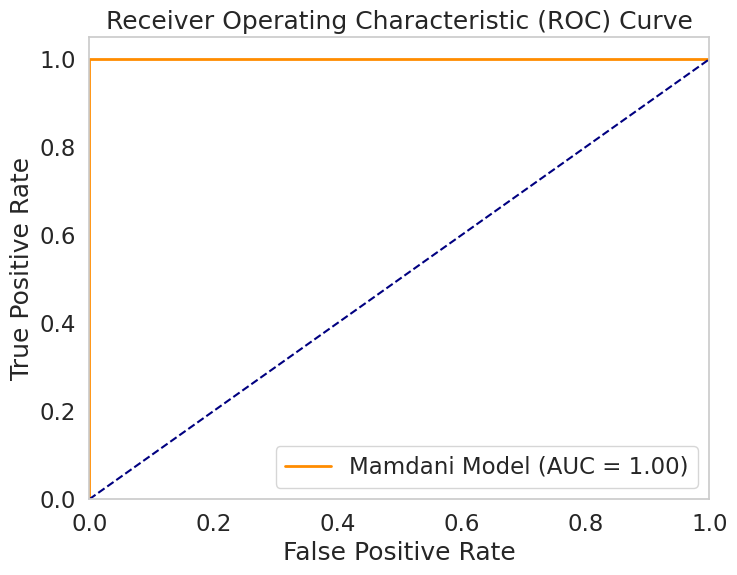

In [12]:
fpr, tpr, _ = roc_curve(y_test, np.array(errors))
roc_auc = auc(fpr, tpr)

# Disegnare la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Mamdani Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonale random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [13]:
def map_fuzzy_set_antecedent(fuzzy_set):
        if "triang" in fuzzy_set.__str__():
            return "medium"
        elif "inf_border" in fuzzy_set.__str__():
            return "low"
        elif "sup_border" in fuzzy_set.__str__():
            return "high"

In [14]:
rule_list = []
for i in range(rule_base.size()):
    rule_list.append(rule_base.printRule(i))
print(rule_list)

[([['P_J3072', triang(x, 0.0, 0.5000000000000001, 1.0000000000000002)], ['P_J3021', inf_border(x, 0.0, 0.4999999999999999)]], ['Y1', inf_border(x, 0, 0.0)], 0.2535442632884777), ([['P_J3071', inf_border(x, 0.0, 0.5000000000000001)], ['P_J3021', inf_border(x, 0.0, 0.4999999999999999)]], ['Y1', inf_border(x, 0, 0.0)], 1), ([['P_J3072', triang(x, 0.0, 0.5000000000000001, 1.0000000000000002)], ['P_J3022', triang(x, 0.0, 0.4999999999999999, 0.9999999999999998)]], ['Y1', inf_border(x, 0, 0.0)], 0.8124648798217615), ([['P_J3071', inf_border(x, 0.0, 0.5000000000000001)], ['P_J3021', inf_border(x, 0.0, 0.4999999999999999)]], ['Y1', inf_border(x, 0, 0.0)], 0.9881749797096937), ([['P_J3071', inf_border(x, 0.0, 0.5000000000000001)], ['P_J3021', inf_border(x, 0.0, 0.4999999999999999)]], ['Y1', inf_border(x, 0, 0.0)], 0.9210445461967997), ([['P_J3071', inf_border(x, 0.0, 0.5000000000000001)], ['P_J3021', inf_border(x, 0.0, 0.4999999999999999)]], ['Y1', inf_border(x, 0, 0.0)], 0.8951185842172448), ([

In [ ]:
def map_fuzzy_set_antecedent(fuzzy_set):
    fuzzy_str = str(fuzzy_set)
    if "triang" in fuzzy_str:
        return "medium"
    elif "inf_border" in fuzzy_str:
        return "low"
    elif "sup_border" in fuzzy_str:
        return "high"
    return "unknown"  # Default nel caso non corrisponda a nessuna categoria

linguistic_rules = []
for antecedent_list, consequent_data, strength in rule_list:
    antecedent_str_parts = []
    
    # Rimuoviamo solo l'ultimo numero dai sensori
    for var, fuzzy_set in antecedent_list:
        # Rimuove solo l'ultimo numero dalla fine del nome del sensore
        var_clean = re.sub(r'(\d)$', '', var)  # Rimuove solo l'ultimo numero
        antecedent_str_parts.append(f"{var_clean} is {map_fuzzy_set_antecedent(fuzzy_set)}")
    
    antecedent_str = " and ".join(antecedent_str_parts)
    
    # Modifica il conseguente
    consequent_var, consequent_fuzzy_set = consequent_data
    consequent_var = "Y1" if consequent_var == "Y2" else consequent_var
    consequent_str = f"{consequent_var} is normal"
    
    # Crea la regola linguistica
    rule_str = f"if {antecedent_str} then {consequent_str}"
    linguistic_rules.append(rule_str)

# Rimuove eventuali duplicati e stampa le regole
rules = list(set(rule.strip() for rule in linguistic_rules))

for rule in rules:
    print(rule)


if P_J307 is medium and P_J302 is low then Y1 is normal
if P_J307 is medium and P_J302 is medium then Y1 is normal
if P_J307 is low and P_J302 is low then Y1 is normal
if P_J307 is high and P_J302 is high then Y1 is normal


In [25]:
sens_1 = np.linspace(0, 1, 10)
sens_2 = np.linspace(0, 1, 10)
Y1 = np.linspace(0, 0, 1)

# Aggiunto un margine del 5% ai valori minimi e massimi
margin_sens1 = 0.05 * (1 - 0)  # 5% dell'intervallo [0,1]
margin_sens2 = 0.05 * (1 - 0)

# Intervalli rilassati per sens_1
a_sens1 = 0 - margin_sens1
b_sens1 = 0.3  
c_sens1 = 1 + margin_sens1  

# Intervalli rilassati per sens_2
a_sens2 = 0 - margin_sens2
b_sens2 = 0.5  
c_sens2 = 1 + margin_sens2  

# Funzioni di appartenenza per sens_1 (con intervalli rilassati)
mf1_sens1 = fuzz.trimf(sens_1, [a_sens1, a_sens1, b_sens1])  
mf2_sens1 = fuzz.trimf(sens_1, [b_sens1, (b_sens1 + c_sens1) / 2, c_sens1])  
mf3_sens1 = fuzz.trimf(sens_1, [0.8 * c_sens1, c_sens1, c_sens1 + margin_sens1])  

# Funzioni di appartenenza per sens_2 (con intervalli rilassati)
mf1_sens2 = fuzz.trimf(sens_2, [a_sens2, a_sens2, b_sens2])  
mf2_sens2 = fuzz.trimf(sens_2, [b_sens2, (b_sens2 + c_sens2) / 2, c_sens2])  
mf3_sens2 = fuzz.trimf(sens_2, [0.9 * c_sens2, c_sens2, c_sens2 + margin_sens2]) 

# Funzione di appartenenza per Y1
mf1_Y1 = fuzz.trimf(Y1, [0, 0, 1])

qfie = FE.QuantumFuzzyEngine(verbose=False)
qfie.input_variable(name='P_J307', range=sens_1)
qfie.input_variable(name='P_J302', range=sens_2)
qfie.output_variable(name='Y1', range=Y1)
qfie.add_input_fuzzysets(var_name='P_J307', set_names=['low', 'medium', 'high'], sets=[mf1_sens1, mf2_sens1, mf3_sens1])
qfie.add_input_fuzzysets(var_name='P_J302', set_names=['low', 'medium', 'high'], sets=[mf1_sens2, mf2_sens2, mf3_sens2])
qfie.add_output_fuzzysets(var_name='Y1', set_names=['normal'],sets=[mf1_Y1])

#RULES GENERATED BY PSO (TRAINING) and PATTERN SEARCH (TUNING):

rules_1 = ['if P_J307 is low and P_J302 is low then Y1 is normal',
           'if P_J302 is low then Y1 is normal',
           'if P_J307 is high and P_J302 is high then Y1 is normal',
           'if P_J307 is medium then Y1 is normal']

#RULES GENERATED BY PSO (TRAINING) and Simulated Annealing (TUNING):

rules_2 = ['if P_J307 is low and P_J302 is high then Y1 is normal',
           'if P_J307 is low then Y1 is normal',
           'if P_J307 is high and P_J302 is high then Y1 is normal',
           'if P_J307 is medium and P_J302 is medium then Y1 is normal'
           ]
    
#RULES GENERATED BY Genetic Algorithm (TRAINING) and Pattern Search (TUNING):
    
rules_3 =  ['if P_J307 is low and P_J302 is low then Y1 is normal',
            'if P_J302 is low then Y1 is normal',
            'if P_J307 is high and P_J302 is high then Y1 is normal',
            'if P_J307 is medium then Y1 is normal']

#RULES GENERATED BY Genetic Algorithm (TRAINING) and Simulated Annealing(TUNING):

rules_4 = ['if P_J307 is low and P_J302 is high then Y1 is normal',
           'if P_J307 is low then Y1 is normal',
           'if P_J307 is high and P_J302 is high then Y1 is normal',
           'if P_J307 is medium and P_J302 is medium then Y1 is normal'
           ]

qfie.set_rules(rules_4)

In [26]:
f_quantum = []
i = 0
errors = []
# Threshold FISSO per rilevare anomalie basato sull'errore di ricostruzione
THRESHOLD = 0
    
for row in X_test: 
    
    input_values = {
        'P_J307': row[0],
        'P_J302': row[1]
    }
        
        
    # Costruct Quantum Circuit for Inference
    qfie.build_inference_qc(input_values, draw_qc=True, filename=f"q_rules_2/quantum_BATADAL_rule_4.pdf")
    i = i + 1
            
    try:
        # Quantum Inference
        predicted_value = qfie.execute(n_shots=1000, plot_histo=True)[0]

        # Calcolo dell'errore di ricostruzione rispetto all'etichetta reale
        error = mean_squared_error([y_test[i - 1]], [predicted_value])

        # Salvataggio dell'errore
        errors.append(error)

        # Se l'errore supera la soglia fissa, assegniamo l'etichetta 1 (anomalia)
        if error > THRESHOLD:
            result = 1
        else:
            result = predicted_value
    except EmptyMembershipError:
            # Se l'errore EmptyMembershipError si verifica, assegniamo direttamente l'etichetta 1
            result = 1
            errors.append(THRESHOLD + 0.01)  # Se l'errore si verifica, inseriamo l'etichetta 1

    f_quantum.append(result)

draw
          ┌────────────────────────────────────────┐┌───┐     ┌───┐ ░ ┌───┐»
P_J307_0: ┤0                                       ├┤ X ├──■──┤ X ├─░─┤ X ├»
          │  Initialize(0.30577,0.22691,0,0.92467) │├───┤  │  ├───┤ ░ ├───┤»
P_J307_1: ┤1                                       ├┤ X ├──■──┤ X ├─░─┤ X ├»
          └──┬──────────────────────────────────┬──┘├───┤  │  ├───┤ ░ └───┘»
P_J302_0: ───┤0                                 ├───┤ X ├──■──┤ X ├─░──────»
             │  Initialize(0.62477,0,0,0.78081) │   └───┘  │  └───┘ ░      »
P_J302_1: ───┤1                                 ├──────────■────────░──────»
             └──────────────────────────────────┘        ┌─┴─┐      ░      »
      Y1: ───────────────────────────────────────────────┤ X ├──────░──────»
                                                         └───┘      ░      »
  c174: 1/═════════════════════════════════════════════════════════════════»
                                                                       

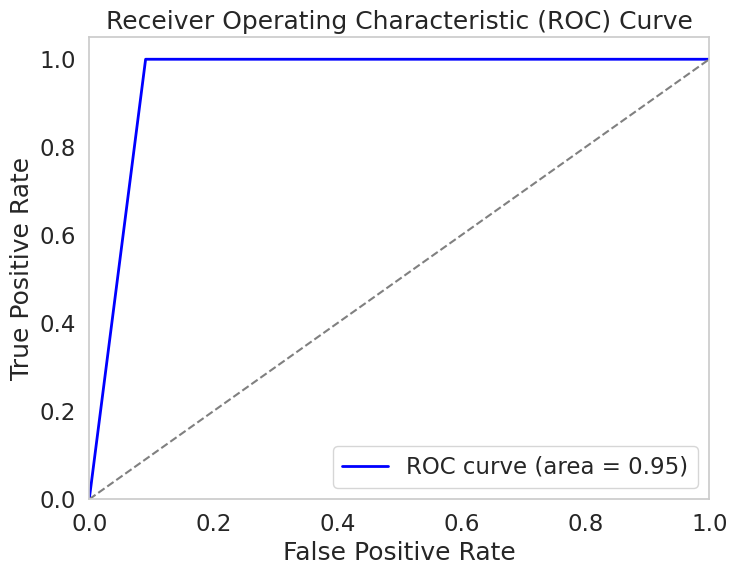

In [27]:
fpr, tpr, _ = roc_curve(y_test, np.array(f_quantum))
roc_auc = auc(fpr, tpr)

# Disegno della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linea diagonale per riferimento
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("q_rules_2/roc_curve_4.png", dpi=300, bbox_inches='tight')